### Import packages

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.preprocessing import scale, StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import seaborn as sns
from datetime import datetime


In [9]:
# Dataset imported from AdhereR
tidy_df = pd.read_csv('./data/med_events.csv')
tidy_df.columns = ['pnr', 'eksd', 'perday', 'ATC', 'dur_original'] # Rename columns to remain consistency with R
tidy_df['eksd'] = pd.to_datetime(tidy_df['eksd'], format='%m/%d/%Y')

tidy_df.head()


,pnr,eksd,perday,ATC,dur_original
0,1,2033-04-26,4,medA,50
1,1,2033-07-04,4,medB,30
2,1,2033-08-03,4,medB,30
3,1,2033-08-17,4,medB,30
4,1,2033-10-13,4,medB,30


Sessa Empirical Estimator using K-Means

In [13]:
def See(arg1):
    C09CA01 = tidy_df[tidy_df['ATC'] == arg1]
    Drug_see_p0 = C09CA01.copy()
    Drug_see_p1 = C09CA01.copy()

    Drug_see_p1 = Drug_see_p1.sort_values(by=['pnr', 'eksd'])
    Drug_see_p1['prev_eksd'] = Drug_see_p1.groupby('pnr')['eksd'].shift(1)
    Drug_see_p1 = Drug_see_p1.dropna(subset=['prev_eksd'])
    Drug_see_p1 = Drug_see_p1.groupby('pnr').apply(lambda x: x.sample(1)).reset_index(drop=True)
    Drug_see_p1['event_interval'] = (Drug_see_p1['eksd'] - Drug_see_p1['prev_eksd']).dt.days

    # Compute ECDF
    ecdf = Drug_see_p1['event_interval'].value_counts().sort_index().cumsum() / len(Drug_see_p1)
    dfper = pd.DataFrame({'x': ecdf.index, 'y': ecdf.values})
    dfper = dfper[dfper['y'] <= 0.8]
    ni = dfper['x'].max()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(dfper['x'], dfper['y'], label='80% ECDF')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.scatter(ecdf.index, ecdf.values, label='100% ECDF')
    plt.legend()
    plt.show()

    Drug_see_p2 = Drug_see_p1[Drug_see_p1['event_interval'] <= ni]
    density = gaussian_kde(np.log(Drug_see_p2['event_interval']))
    x = np.linspace(min(np.log(Drug_see_p2['event_interval'])), max(np.log(Drug_see_p2['event_interval'])), 1000)

    plt.plot(x, density(x))
    plt.title('Log(event interval)')
    plt.show()

    a = pd.DataFrame({'x': x, 'y': density(x)})
    a = pd.DataFrame(scale(a), columns=['x', 'y'])

    # Determine the optimal number of clusters using silhouette scores
    silhouette_scores = []
    for n_clusters in range(2, 11):
        kmeans = KMeans(n_clusters=n_clusters, random_state=1234)
        kmeans.fit(a)
        score = silhouette_score(a, kmeans.labels_)
        silhouette_scores.append((n_clusters, score))
    best_n_clusters = max(silhouette_scores, key=lambda x: x[1])[0]

    kmeans = KMeans(n_clusters=best_n_clusters, random_state=1234)
    kmeans.fit(dfper[['x']])
    dfper['cluster'] = kmeans.labels_

    cluster_summary = dfper.groupby('cluster')['x'].agg(['min', 'max', 'median']).reset_index()
    results = Drug_see_p1.merge(cluster_summary, left_on='event_interval', right_on='x', how='left')
    results['cluster'] = results['cluster'].fillna(0).astype(int)
    results['Median'] = results['median'].apply(np.exp)
    results = results[['pnr', 'Median', 'cluster']]
    
    t1 = results['cluster'].value_counts().idxmax()
    t1_merged = results[results['cluster'] == t1].iloc[0]

    Drug_see_p1 = Drug_see_p1.merge(results, on='pnr', how='left')
    Drug_see_p1['Median'] = Drug_see_p1['Median'].fillna(t1_merged['Median'])
    Drug_see_p1['cluster'] = Drug_see_p1['cluster'].fillna(0).astype(int)
    Drug_see_p1['test'] = (Drug_see_p1['event_interval'] - Drug_see_p1['Median']).round(1)
    
    Drug_see_p3 = Drug_see_p1[['pnr', 'Median', 'cluster']]
    Drug_see_p0 = Drug_see_p0.merge(Drug_see_p3, on='pnr', how='left')
    Drug_see_p0['Median'] = Drug_see_p0['Median'].fillna(t1_merged['Median'])
    Drug_see_p0['cluster'] = Drug_see_p0['cluster'].fillna(0).astype(int)
    return Drug_see_p0


In [11]:
def see_assumption(arg1):
    arg1 = arg1.sort_values(by=['pnr', 'eksd'])
    arg1['prev_eksd'] = arg1.groupby('pnr')['eksd'].shift(1)
    
    Drug_see2 = arg1.dropna(subset=['prev_eksd'])
    Drug_see2['p_number'] = Drug_see2.groupby('pnr').cumcount() + 1
    Drug_see2 = Drug_see2[Drug_see2['p_number'] >= 2]
    Drug_see2['Duration'] = (Drug_see2['eksd'] - Drug_see2['prev_eksd']).dt.days

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='p_number', y='Duration', data=Drug_see2)
    plt.title('Duration by Prescription Number')
    plt.show()

    medians_of_medians = Drug_see2.groupby('pnr')['Duration'].median().median()

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='p_number', y='Duration', data=Drug_see2)
    plt.axhline(medians_of_medians, color='red', linestyle='--')
    plt.title('Duration by Prescription Number with Median Line')
    plt.show()

    return plt


C:\Users\Andrew\AppData\Local\Temp\ipykernel_172\2017923214.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Drug_see_p1 = Drug_see_p1.groupby('pnr').apply(lambda x: x.sample(1)).reset_index(drop=True)


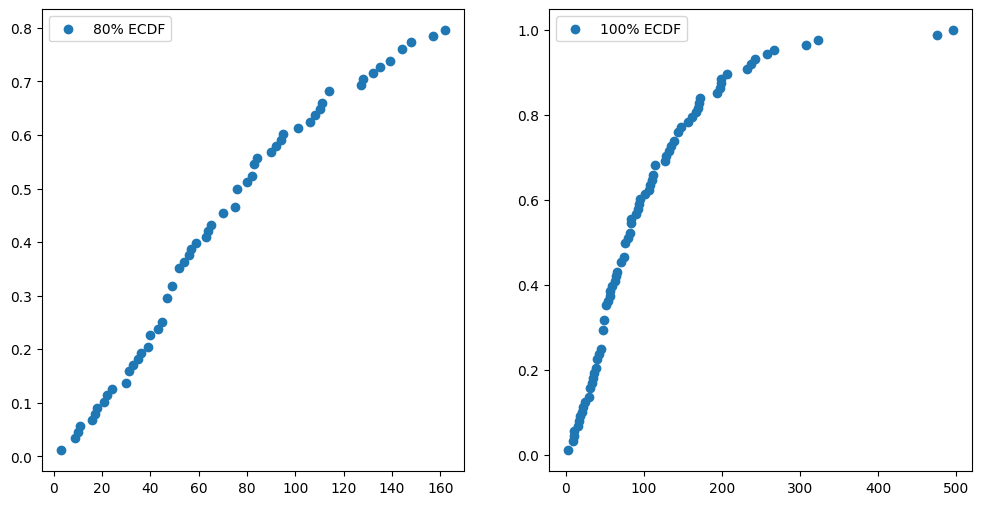

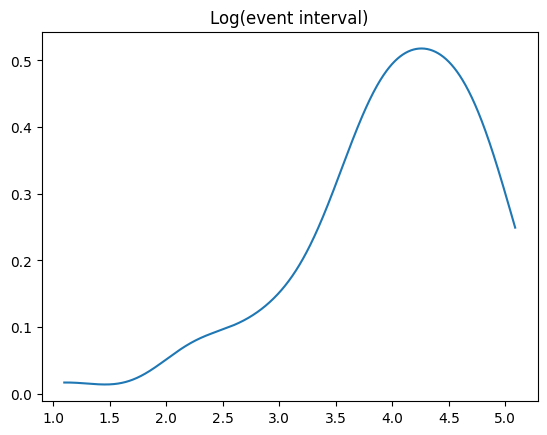

KeyError: 'x'

In [14]:
medA = See('medA')
medB = See('medB')
see_assumption(medA)
see_assumption(medB)

Sessa Empirical Estimator using DBScan

In [15]:
def see_dbscan(arg1):
  C09CA01 = tidy_df[tidy_df['ATC'] == arg1]

  Drug_see_p0 = C09CA01.copy()
  Drug_see_p1 = C09CA01.copy()

  Drug_see_p1 = Drug_see_p1.sort_values(by=['pnr', 'eksd'])
  Drug_see_p1['prev_eksd'] = Drug_see_p1.groupby('pnr')['eksd'].shift(1)
  Drug_see_p1 = Drug_see_p1.dropna(subset=['prev_eksd'])
  Drug_see_p1 = Drug_see_p1.groupby('pnr').apply(lambda x: x.sample(1)).reset_index(drop=True)
  Drug_see_p1['event_interval'] = (Drug_see_p1['eksd'] - Drug_see_p1['prev_eksd']).dt.days

  # Compute ECDF
  ecdf = Drug_see_p1['event_interval'].value_counts().sort_index().cumsum() / len(Drug_see_p1)
  dfper = pd.DataFrame({'x': ecdf.index, 'y': ecdf.values})
  dfper = dfper[dfper['y'] <= 0.8]
  ni = dfper['x'].max()

  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.scatter(dfper['x'], dfper['y'], label='80% ECDF')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.scatter(ecdf.index, ecdf.values, label='100% ECDF')
  plt.legend()
  plt.show()

  Drug_see_p2 = Drug_see_p1[Drug_see_p1['event_interval'] <= ni]

  density = gaussian_kde(np.log(Drug_see_p2['event_interval']))
  x = np.linspace(min(np.log(Drug_see_p2['event_interval'])), max(np.log(Drug_see_p2['event_interval'])), 1000)

  plt.plot(x, density(x))
  plt.title('Log(event interval)')
  plt.show()

  # Normalize data for DBSCAN
  scaled_data = StandardScaler().fit_transform(dfper[['x']])

  # Apply DBSCAN (Tune `eps` and `min_samples`)
  dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust `eps` and `min_samples` for better clustering
  dfper['cluster'] = dbscan.fit_predict(scaled_data)

  # Handle noise points (outliers labeled as -1)
  dfper.loc[dfper['cluster'] == -1, 'cluster'] = np.nan  # Mark outliers as NaN

  # Compute cluster summary
  cluster_summary = dfper.groupby('cluster')['x'].agg(['min', 'max', 'median']).reset_index()

  # Merge clusters back
  results = Drug_see_p1.merge(cluster_summary, left_on='event_interval', right_on='x', how='left')
  results['cluster'] = results['cluster'].fillna(0).astype(int)
  results['Median'] = results['median'].apply(np.exp)
  results = results[['pnr', 'Median', 'cluster']]

  # Assign the most frequent cluster to missing values
  t1 = results['cluster'].value_counts().idxmax()
  t1_merged = results[results['cluster'] == t1].iloc[0]

  Drug_see_p1 = Drug_see_p1.merge(results, on='pnr', how='left')
  Drug_see_p1['Median'] = Drug_see_p1['Median'].fillna(t1_merged['Median'])
  Drug_see_p1['cluster'] = Drug_see_p1['cluster'].fillna(0).astype(int)
  Drug_see_p1['test'] = (Drug_see_p1['event_interval'] - Drug_see_p1['Median']).round(1)

  Drug_see_p3 = Drug_see_p1[['pnr', 'Median', 'cluster']]
  Drug_see_p0 = Drug_see_p0.merge(Drug_see_p3, on='pnr', how='left')
  Drug_see_p0['Median'] = Drug_see_p0['Median'].fillna(t1_merged['Median'])
  Drug_see_p0['cluster'] = Drug_see_p0['cluster'].fillna(0).astype(int)

  return Drug_see_p0

C:\Users\Andrew\AppData\Local\Temp\ipykernel_172\1080560637.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Drug_see_p1 = Drug_see_p1.groupby('pnr').apply(lambda x: x.sample(1)).reset_index(drop=True)


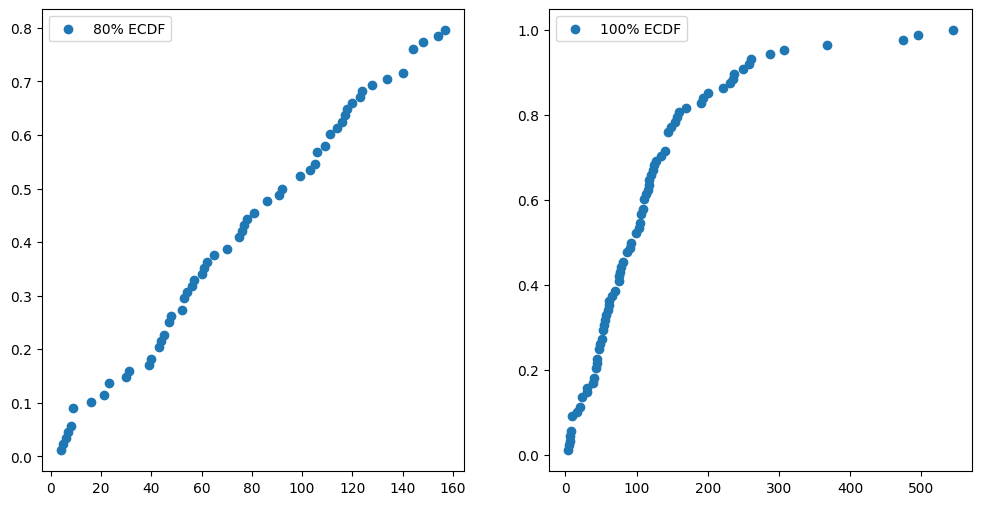

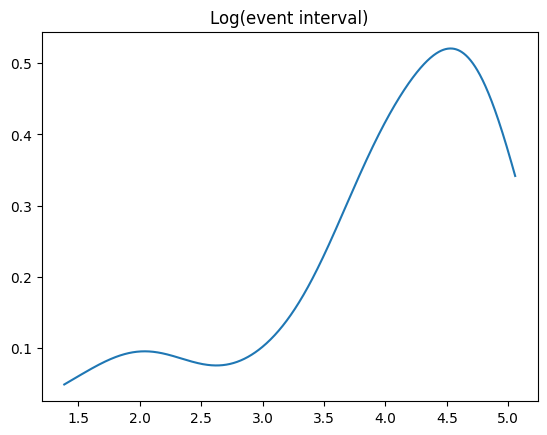

KeyError: 'x'

In [16]:
medA_dbscan = see_dbscan('medA')
medB_dbscan = see_dbscan('medB')
see_assumption(medA_dbscan)
see_assumption(medB_dbscan)